# Cosine angle metric for pairs trading

Ideally we'd be making money with both bearish and bullish tickers in a pairs trade. There's an optimization metric we can create by using the angle between the trade PNLs to determine if a strategy is gaining on both sides.

We want the angle to be closest to 0. Cosine of the angle might be handy too.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Setting some constraints
STARTING_VALUE = 100
MINIMUM_VALUE = STARTING_VALUE * 0.2

In [3]:
# Create dates for 3 years
dates = pd.date_range(start="2021-01-01", end="2023-12-01", freq="MS")

In [4]:
import math

def dot_product(v1, v2):
    return v1[0]*v2[0] + v1[1]*v2[1]

def magnitude(v):
    return math.sqrt(v[0]**2 + v[1]**2)

def angle_between_lines(A, B, C, D):
    # Calculate direction vectors for the lines using only y differences
    u = (1, B[1] - A[1])  # 1, y2-y1
    v = (1, D[1] - C[1])  # 1, y4-y3
    
    cos_theta = dot_product(u, v) / (magnitude(u) * magnitude(v))
    
    # Clip cos_theta to handle potential floating point errors
    cos_theta = max(-1.0, min(1.0, cos_theta))
    
    return math.degrees(math.acos(cos_theta))

# Test
A, B = (0, 10), (1, 20)
C, D = (0, 20), (1, 10)

angle = angle_between_lines(A, B, C, D)
print(f"Angle between the lines: {angle} degrees")

Angle between the lines: 168.5788137250007 degrees


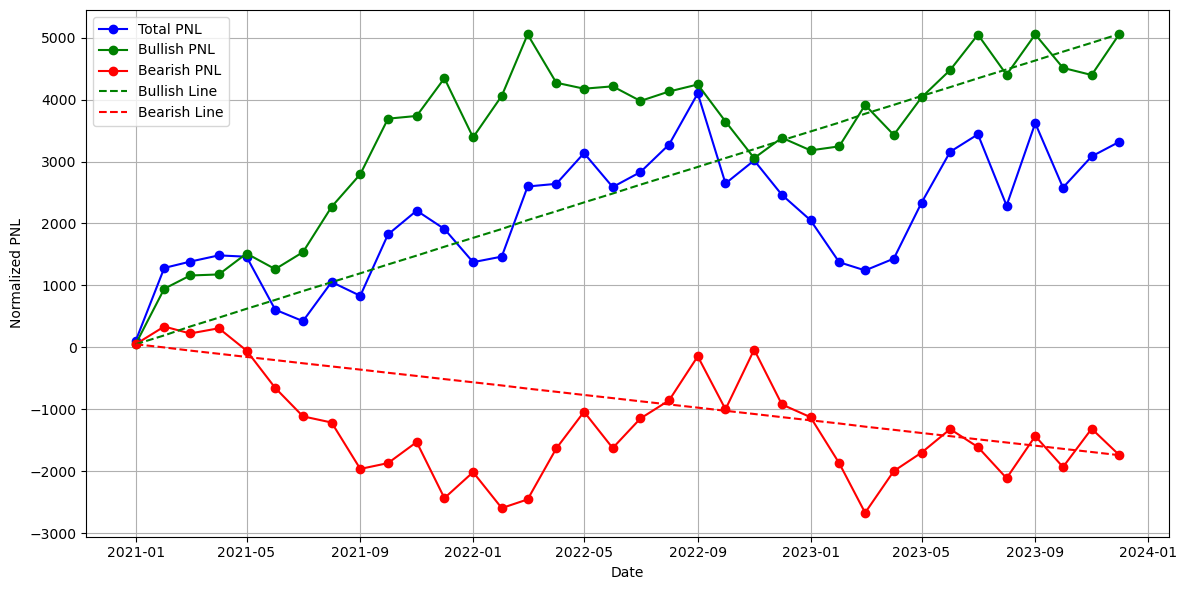

Angle between the lines: 84.41748335852233 degrees
The cosine metric is: 0.9027207906281876


In [5]:
trade = {
    'bullish': [],
    'bearish': [],
    'cumulative': [],
}

bullish = STARTING_VALUE / 2
bearish = STARTING_VALUE / 2

for date in dates:
    bullish_temp = bullish
    bearish_temp = bearish
    trade['bullish'].append(bullish)
    trade['bearish'].append(bearish)
    trade['cumulative'].append(bullish + bearish)
    while True:
        bullish = bullish_temp + random.randint(-1000, 1000)
        bearish = bearish_temp + random.randint(-1000, 1000)
        if ( bullish + bearish ) > MINIMUM_VALUE:
            break

X = np.array(range(len(dates)))

# overall
y1, y2 = trade['cumulative'][0], trade['cumulative'][-1]
straight_line_values = y1 + (y2 - y1) / (X[-1] - X[0]) * (X - X[0])
trade['line'] = straight_line_values

# bearish
y1, y2 = trade['bullish'][0], trade['bullish'][-1]
straight_line_values = y1 + (y2 - y1) / (X[-1] - X[0]) * (X - X[0])
trade['bullish_line'] = straight_line_values


# bullish
y1, y2 = trade['bearish'][0], trade['bearish'][-1]
straight_line_values = y1 + (y2 - y1) / (X[-1] - X[0]) * (X - X[0])
trade['bearish_line'] = straight_line_values

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'bullish': trade['bullish'],
    'bearish': trade['bearish'],
    'trade_pnl': trade['cumulative'],
    'bullish_line': trade['bullish_line'],
    'bearish_line': trade['bearish_line']
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['trade_pnl'], marker='o', linestyle='-', color='b', label="Total PNL")
plt.plot(df['date'], df['bullish'], marker='o', linestyle='-', color='g', label="Bullish PNL")
plt.plot(df['date'], df['bearish'], marker='o', linestyle='-', color='r', label="Bearish PNL")
plt.plot(df['date'], df['bullish_line'], color='g', linestyle='--', label="Bullish Line")
plt.plot(df['date'], df['bearish_line'], color='r', linestyle='--', label="Bearish Line")
plt.xlabel('Date')
plt.ylabel('Normalized PNL')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Normalize the end values
bearish_normalized = (trade['cumulative'][-1] - trade['bearish'][-1]) / trade['cumulative'][-1] 
bullish_normalized = (trade['cumulative'][-1] - trade['bullish'][-1]) / trade['cumulative'][-1] 

A, B = (0, 0), (1, bearish_normalized)
C, D = (0, 0), (1, bullish_normalized)

angle = angle_between_lines(A, B, C, D)
print(f"Angle between the lines: {angle} degrees")

cos_value = math.cos(math.radians(angle))
print(f"The cosine metric is: {1-abs(cos_value)}")